In [1]:
import os
import pandas as pd
import numpy as np
import plotnine as p9
import patchworklib as pw

<Figure size 100x100 with 0 Axes>

In [2]:
import plotnine as p9

def create_mosaic_plot(data, metric, cmap='viridis'):
    """
    Create a mosaic plot using plotnine with faceting on the 'dataset' column.

    :param data: DataFrame with columns 'reduction_name', 'score_key', 'AUROC', and 'dataset'.
    :return: The plotnine plot object.
    """
    # Create the plot
    plot = (p9.ggplot(data, p9.aes(x='reduction_name', y='score_key', fill=metric)) +
            p9.geom_tile() +
            p9.theme_bw(base_size=11) +
            p9.facet_grid(' ~ dataset') +
            p9.scale_fill_cmap(limits=(0.5, 1), cmap_name=cmap) +
            p9.geom_text(p9.aes(label=metric), size=10, color='white', fontweight='bold') +
            p9.theme(figure_size=(9, 4), 
                     axis_text_x=p9.element_text(angle=90, size=11),
                     strip_text_x=p9.element_text(size=11),
                     strip_background=p9.element_rect(colour="black", fill="#fdfff4"),
                     legend_text=p9.element_text(size=11),
                     axis_text_y=p9.element_text(size=11)) +
            p9.labs(x='', y='', fill=metric))

    return plot


Load Results and Concat

In [3]:
# list output files
file_paths = os.listdir(os.path.join('data', 'results'))
# keep only .csv files
results = [pd.read_csv(os.path.join('data', 'results', p)) for p in file_paths if p.endswith('.csv')]

In [4]:
results = pd.concat(results)

In [5]:
results['AUROC'] = results.groupby(['reduction_name', 'dataset', 'score_key'])['auroc'].transform('mean')
results['F1'] = results.groupby(['reduction_name', 'dataset', 'score_key'])['f1_score'].transform('mean')
results = results[['reduction_name', 'score_key', 'AUROC', 'F1', 'dataset']].drop_duplicates()

In [6]:
remap_dict = {'lr_means':'CellPhoneDB',
              'expr_prod':'Product',
              'lr_logfc': 'logFC',
              'lrscore': 'SingleCellSignalR',
              'lr_probs': 'CellChat',
              'magnitude_rank':'Rank Aggregate',
              'inter_score': 'scSeqComm',
              'lr_gmeans': 'Geometric Mean',
              }
# Prettify names
results['score_key'] = results['score_key'].map(remap_dict)
results['reduction_name'] = results['reduction_name'].replace({"mofa":"MOFA+", 'tensor':"Tensor-cell2cell"})

In [7]:
# mean rank per Method
score_avg = results.groupby(['score_key', 'reduction_name'])[['AUROC', 'F1']].agg('mean')
score_avg['dataset'] = "Score Average"
results = pd.concat([results, score_avg.reset_index()])
results['AUROC'] = results['AUROC'].round(2)
results['F1'] = results['F1'].round(2)

In [8]:
# to title
results['dataset'] = results['dataset'].replace({'Score Average': 'Average'})
results['dataset'] = pd.Categorical(results['dataset'], categories=['carraro', 'habermann', 'kuppe', 'velmeshev', 'reichart', 'Average'])
results['dataset'] = results['dataset'].str.title()

In [9]:
p1 = create_mosaic_plot(results, metric='AUROC')
g1 = pw.load_ggplot(p1)

In [10]:
p2 = create_mosaic_plot(results, metric='F1', cmap='cividis')
g2 = pw.load_ggplot(p2)

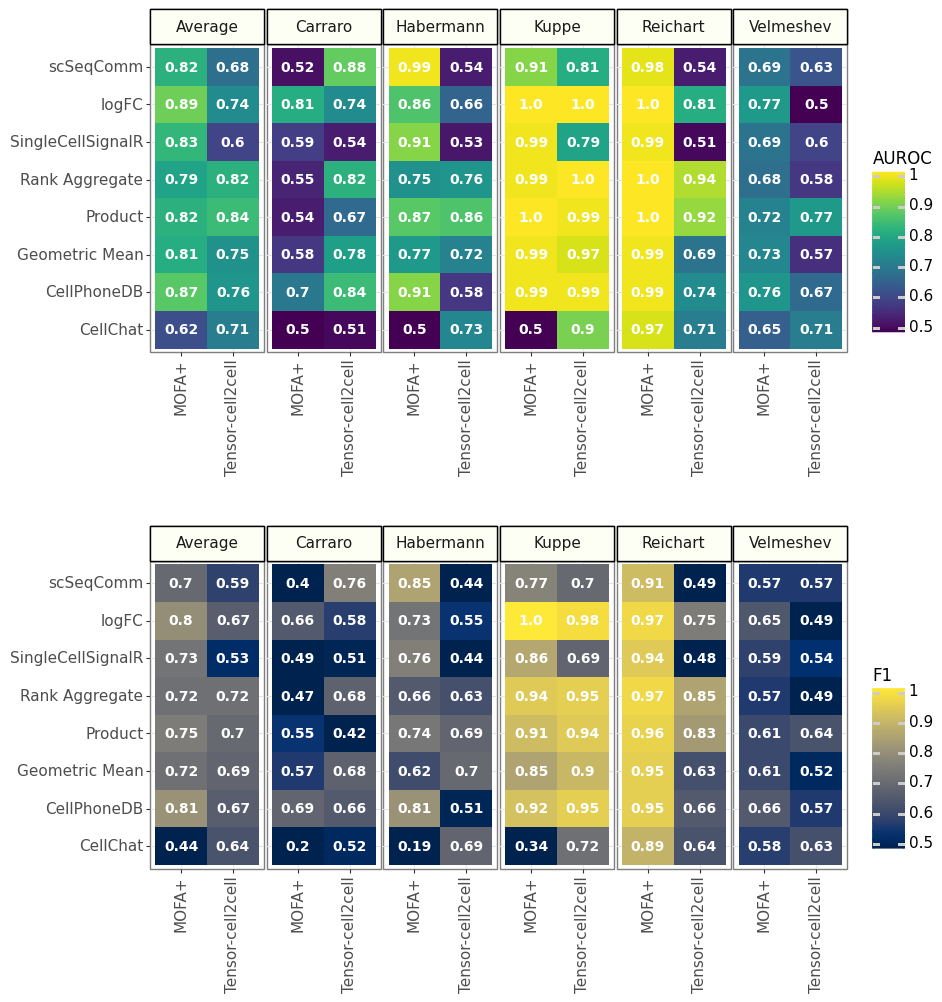

In [11]:
(g1/g2).savefig(os.path.join('..', '..' ,'figures', 'classification.pdf'), dpi=300)

In [12]:
# Move to Excel Sheet
p1.data.to_csv(os.path.join("..", "..", "figures", "source", "Sufig7A&B.csv"))